In [1]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz

In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_val_score
from IPython.display import Image, display_svg, SVG
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
import joblib

max_d = 5
num_est = 80
validation_lookback = 14
train_start_days_past = 90
should_drop_prior_gst = True
lr = 0.1
obj_loss = 'reg:squarederror'

In [3]:
path = Path.cwd()
Path.BASE_PATH = path
dsets_path = path.parent.parent/'fastai/datasets'
df = pd.read_csv(dsets_path/'osrs_trades.csv', low_memory=False)
dep_var = 'gst'
make_date(df, 'timestamp')
df = add_datepart(df, 'timestamp')
df = df.drop('id', axis=1)
df = df.drop('item_id', axis=1)
# if should_drop_prior_gst:
#     df = df.drop('prior_gst', axis=1)
    
procs = [Categorify, FillMissing]
maxDay = df['timestampDayofyear'].max()

minCond = (df.timestampDayofyear>(maxDay - train_start_days_past)) # day 117 is when I fixed date recording on completed_trades
maxCond = (df.timestampDayofyear<=(maxDay - validation_lookback))
train_idx = np.where((maxCond) & (minCond))[0]
valid_idx = np.where(~maxCond)[0]

splits = (list(train_idx),list(valid_idx))
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
save_pickle(path/'preprocessed_train_valid.pkl', to)

/home/tristan/Documents/dev/ML_exercises/random_forest/default/lib/python3.12/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [4]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [5]:
xg_reg = xgb.XGBRegressor(objective=obj_loss, colsample_bytree=0.3, learning_rate=lr,
                          max_depth=max_d, alpha=10, n_estimators=num_est)
xg_reg.fit(xs, y)

y_pred = xg_reg.predict(valid_xs)
mse = mean_squared_error(valid_y, y_pred)

def accuracy(pred, y): return round(abs(y - pred).mean(), 2)
def m_accuracy(preds, y): return accuracy(preds, y)

accuracy = m_accuracy(y_pred, valid_y)
rmse = np.sqrt(mse)

rmse, accuracy

(65.97063, 44.01)

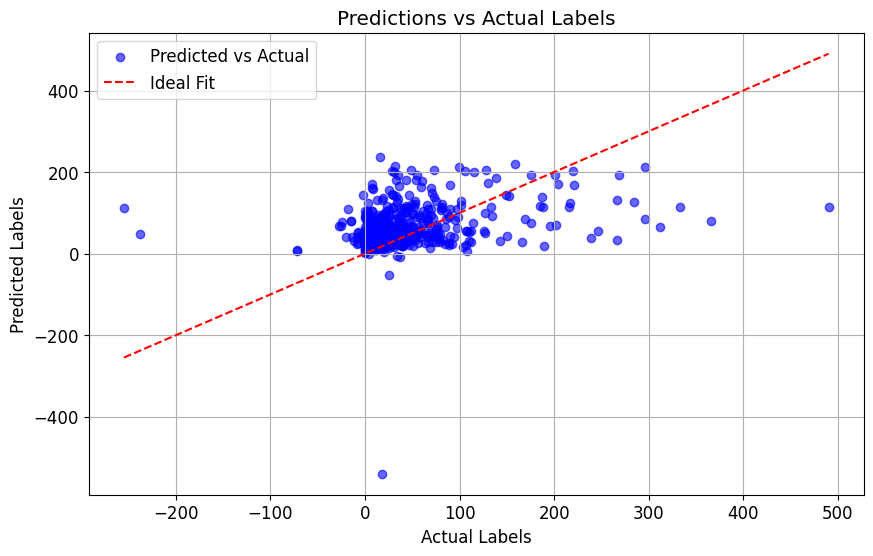

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(valid_y, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(valid_y), max(valid_y)], [min(valid_y), max(valid_y)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predictions vs Actual Labels')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# joblib.dump(xg_reg, '/home/tristan/Documents/dev/ge_bot/prediction_api/xg_boost_model.pkl')

In [8]:
xs.columns

Index(['timestampYear', 'timestampIs_month_end', 'timestampIs_month_start',
       'timestampIs_quarter_end', 'timestampIs_quarter_start',
       'timestampIs_year_end', 'timestampIs_year_start', 'player_count',
       'high_price_5m', 'low_price_5m', 'high_volume_5m', 'low_volume_5m',
       'high_price_1h', 'low_price_1h', 'high_volume_1h', 'low_volume_1h',
       'timestampMonth', 'timestampWeek', 'timestampDay', 'timestampDayofweek',
       'timestampDayofyear', 'timestampElapsed'],
      dtype='object')